# Ensemble : Bagging

## 1.환경준비

### (1) import

In [2]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [3]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


## 2.데이터 준비

### (1) 데이터 정리

In [4]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [5]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [6]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (5) 데이터분할2 : train : validation

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

## 3.모델링 : 랜덤포레스트


In [8]:
# 모델 선언
model = RandomForestClassifier(n_estimators = 5, max_depth = 3)

In [9]:
# 학습
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=5)

In [10]:
# 예측
pred = model.predict(x_val)

In [11]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.64      0.74      0.68       769
           1       0.67      0.56      0.61       731

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.65      0.65      0.65      1500



## 4.시각화와 변수중요도

### (1) 모델의 내부를 살펴봅시다.

In [ ]:
# 5개 decision tree
model.estimators_

In [ ]:
# 각 트리별로 시각화 할 수 있다.
plt.figure(figsize=(20,6))
plot_tree(model.estimators_[0], 
               feature_names = x_train.columns,
               class_names= ['LEAVE','STAY'], 
               filled = True, fontsize = 8);

### (2) 변수 중요도

In [ ]:
# 변수 중요도
print(x_train.columns)
print(model.feature_importances_)

* 변수중요도 그래프 그리기 함수 만들기

In [ ]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

In [ ]:
result = plot_feature_importance(model.feature_importances_, x_train.columns)

## 5.실습: random forest 튜닝

* grid search를 수행합니다.
    * ① n_estimators 의 갯수를 5 ~ 200까지 5개씩 증가시켜가며 튜닝해 봅시다.
    * ② max_features를 1 ~ feature갯수까지 1씩 증가시켜가며 튜닝해 봅시다.
    * ③ n_estimators, max_features를 동시에 튜닝.

* 모델링 후 cv 평가 결과를 차트로 그려봅시다. 
* 튜닝된 모델로 부터 변수중요도를 뽑아 봅시다.


### (1) n_estimators 튜닝

### (2) max_features 튜닝

In [13]:
x_train.shape # 열 개수 만큼 수 조절 가능

(3500, 20)

In [14]:
params = {'max_features': range(1, 21)}

In [15]:
# 모델 선언: 기본 모델
model = RandomForestClassifier()

# 모델 선언: Grid Search
model_gs = GridSearchCV(model, params, cv = 5)
# model_gs = GridSearchCV(RandomForestClassifier(), params, cv = 5) 형식으로도 작성 가능

In [16]:
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 21)})

In [17]:
model_gs.best_params_

{'max_features': 3}

In [18]:
result = pd.DataFrame(model_gs.cv_results_)
tmp = result.loc[:, ['param_max_features', 'mean_test_score']]
tmp.head()

,param_max_features,mean_test_score
0,1,0.661429
1,2,0.680286
2,3,0.689429
3,4,0.684000
4,5,0.684571


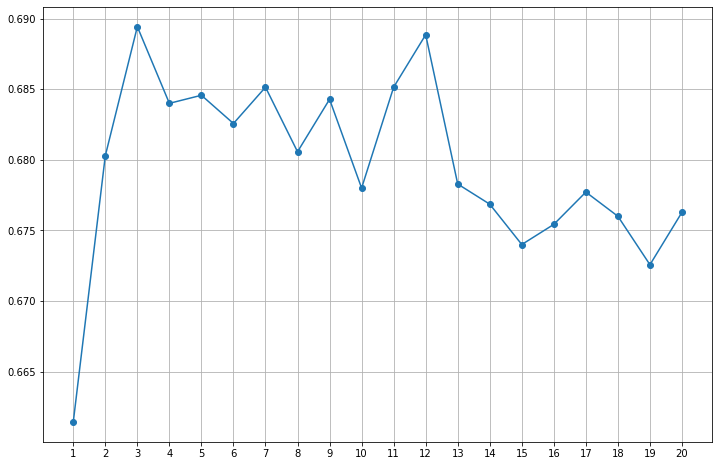

In [21]:
plt.figure(figsize=(12, 8))
plt.plot('param_max_features', 'mean_test_score', data=tmp, marker='o')
plt.xticks(range(1,21))
plt.grid()
plt.show()

* 변수 중요도

### (3) n_estimators와 max_features를 한꺼번에 튜닝

In [22]:
params = {'n_estimators': range(10, 210, 10), 'max_features': range(1, 21)}

In [23]:
m_gs = GridSearchCV(RandomForestClassifier(), params, cv = 5)

In [24]:
m_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 21),
                         'n_estimators': range(10, 210, 10)})

In [25]:
m_gs.best_params_

{'max_features': 8, 'n_estimators': 160}

In [26]:
result = pd.DataFrame(m_gs.cv_results_)
tmp = result.loc[:, ['param_n_estimators', 'param_max_features', 'mean_test_score']]
tmp.head()

,param_n_estimators,param_max_features,mean_test_score
0,10,1,0.623429
1,20,1,0.638000
2,30,1,0.650286
3,40,1,0.649429
4,50,1,0.655143


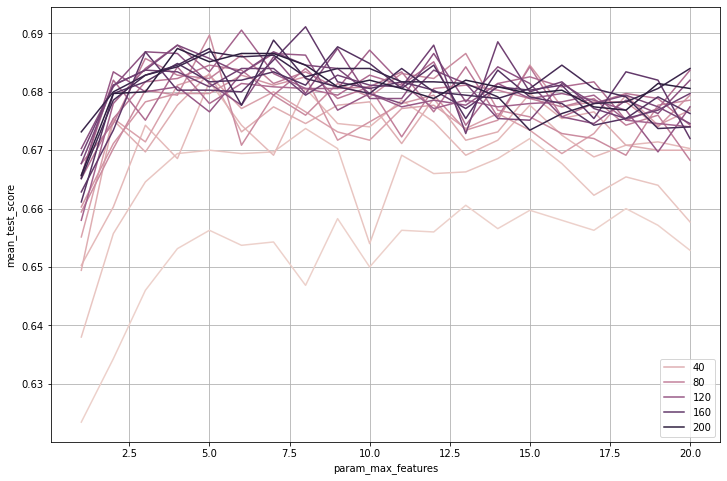

In [29]:
plt.figure(figsize=(12, 8))
# plt.plot('param_n_estimators', 'mean_test_score', 's', data=tmp, label='estimator')
# plt.plot('param_max_features', 'mean_test_score', 'o', data=tmp, label='feature')
sns.lineplot('param_max_features', 'mean_test_score', data = tmp , hue = 'param_n_estimators')
# 'n_estimator' = [20, 50, 100]
plt.legend()
plt.grid()
plt.show()